# Part 5: PCA and Modelling

In this notebook, I will bring in the data and performing modelling. Specifically, I will perform dimensionality reduction via PCA and subsequently, KMeans Clustering.

Here are the steps to be undertaken:
1. Perform Tokenization
2. Scale numeric features
3. Perform PCA
4. Run several models and optimize hyperparameters
5. Choose optimal model for KMeans

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import custom functions
import functions_library as fl

In [3]:
#let's bring in the beauty review dataset with the cleaning and feature engineering steps applied
df = fl.pipedf('All_Beauty.json.gz')

### 1. Perform Tokenization

- For reviewText, will use: lemmatizer, ngrams 1-2, **min_df = 1000**
- For summary, will use: lemmatizer, ngrams 1-2, **min_df = 800**

In [ ]:
#getting review tokens which will be prepended with 'r_'
review_tokens = fl.tfidf(df['reviewText'], tokenizer=fl.spl_tokenizer, ngram_range=(1,2), min_df=1750)

C:\Users\bucco\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [5]:
#getting summary tokens which will be prepended with 's_'
summary_tokens = fl.tfidf(df['summary'], tokenizer=fl.spl_tokenizer, ngram_range=(1,2), min_df=1000)

### 2. Scale numeric features
Will be using the MinMaxScaler to scale the non-token features.

In [4]:
#getting the numeric features (no tokens)
df2=df.select_dtypes(include=['int32','int64'])

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
#instantiate minmaxscaler
mm = MinMaxScaler()

In [7]:
#fit transform data using minmaxscaler
df3 = mm.fit_transform(df2)

In [8]:
#put the scaled into a dataframe
df_scaled = pd.DataFrame(df3, columns = df2.columns)

In [9]:
df_scaled.shape

(362252, 12)

In [10]:
#saving memory
del df3, df2

#### Now let's bring in the tokens to get the final dataframe.

In [11]:
#concatenating the scaled non-token features and the review & summary tokens
df_final = pd.concat([df_scaled, review_tokens, summary_tokens], axis = 1)

NameError: name 'review_tokens' is not defined

In [14]:
#save data
df_final.to_csv('all_tokens_scaled.zip', compression='zip')

In [14]:
df_final.tail()

,overall,verified,vote,review_word_count,summary_word_count,month,dayofweek,multipleReviews_reviewer,reviewer_five_star_only,reviewer_one_star_only,...,s_way,s_well,s_wonderful,s_work,s_work s_great,s_work s_well,s_worked,s_worth,s_would,s_year
362247,0.00,1.0,0.000000,0.011057,0.087248,0.545455,0.500000,0.0,0.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362248,1.00,1.0,0.012495,0.017199,0.006711,0.181818,0.500000,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362249,1.00,1.0,0.016906,0.001638,0.013423,0.181818,0.333333,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362250,0.25,1.0,0.000000,0.011057,0.060403,0.090909,0.166667,0.0,0.0,0.0,...,0.545842,0.457313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362251,0.25,1.0,0.000000,0.012695,0.053691,1.000000,0.500000,1.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#saving memory
del review_tokens, summary_tokens, df_scaled, df

### 3. Perform PCA
As we have seen above, the final dataframe contains 1347 features so this dataset is a good candidate for dimensionality reduction. Will do so using PCA.

In [16]:
#import PCA
from sklearn.decomposition import PCA

In [17]:
# Create a PCA instance: pca
pca = PCA(n_components=500)
pcs = pca.fit_transform(df_final)

In [12]:
# Plot the explained variances
plt.figure(figsize=(10,4))
plt.plot(range(500), pca.explained_variance_ratio_[0:500])
plt.xlabel('PCA features')
plt.ylabel('explained variance %')
plt.xticks(range(0,501,25))
plt.title('Explained variance % of Principal Components')
plt.show()

NameError: name 'pca' is not defined

<Figure size 720x288 with 0 Axes>

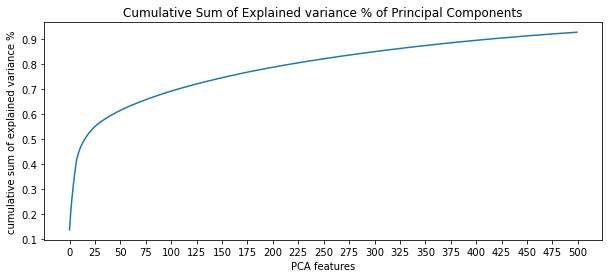

In [19]:
# Plot the cumulative sum of explained variances
plt.figure(figsize=(10,4))
plt.plot(range(500), pca.explained_variance_ratio_.cumsum()[0:500])
plt.xlabel('PCA features')
plt.ylabel('cumulative sum of explained variance %')
plt.xticks(range(0,501,25))
plt.title('Cumulative Sum of Explained variance % of Principal Components')
plt.show()

From the above, we want to have as much explained variance as possible from the least number of principal components. As a rough guide, I want to be able to have at least 80% explained variance.

In [25]:
#explained variance for 300 PCs
pca.explained_variance_ratio_.cumsum()[230]

0.8075446936896741

In [26]:
#explained variance for 350 PCs
pca.explained_variance_ratio_.cumsum()[240]

0.8140070367905118

In [27]:
#explained variance for 300 PCs
pca.explained_variance_ratio_.cumsum()[250]

0.820255825732062

300 PCs provides 80% explained variance. 400 PCs gets close to 85%. For later modelling, let's try using **350 PCs** as we get a decent tradeoff: 50 more features for 2.2% increase in explained variance compared to 300 PCs. I note that this may not provide the optimal settings to build a model but the model can always be improved in later iterations of this project.

In [28]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(pcs)

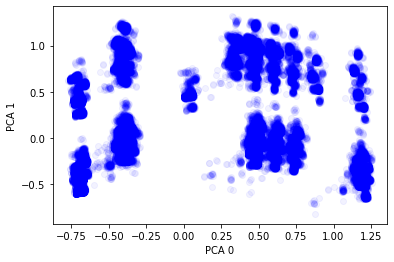

In [29]:
#this is what the first two features look like (plot)
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], alpha=.05, color='blue')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.show()

## KMeans Clustering
The moment we have been waiting for. We can now begin building our model. For this project I would like to try using Kmeans clustering. Additionally, I will try using LDA topic modelling, which will be performed in a separate notebook.

In [30]:
from sklearn.cluster import KMeans

In [31]:
#we begin by trying to determine the optimal number of clusters by looking at inertia scores
#cycle through different K values and append inertia score to list
k_values = range(8,32)
inertia_scores = []

for k in k_values:
    #instantiate
    kmeans_model = KMeans(n_clusters=k, init="k-means++",n_init=1, verbose=1)
    #fitting on first 350 PCs
    kmeans_model.fit(PCA_components.iloc[:,0:230])
    #get scores and append them
    inertia = kmeans_model.inertia_
    #append score
    inertia_scores.append(inertia)

Initialization complete
Iteration 0, inertia 878577.9555449251
Iteration 1, inertia 594296.7177531639
Iteration 2, inertia 565290.9652329603
Iteration 3, inertia 552022.9942541465
Iteration 4, inertia 550908.7076732523
Iteration 5, inertia 550859.2874702403
Iteration 6, inertia 550823.6895615499
Iteration 7, inertia 550731.1852494371
Iteration 8, inertia 550519.3357477989
Iteration 9, inertia 550049.5175478916
Iteration 10, inertia 549424.9669748793
Iteration 11, inertia 548971.6983195733
Iteration 12, inertia 548899.1808334637
Iteration 13, inertia 548894.5559723608
Iteration 14, inertia 548892.3063809769
Iteration 15, inertia 548891.4419424244
Iteration 16, inertia 548890.9103580725
Iteration 17, inertia 548890.3989904631
Iteration 18, inertia 548890.1847830542
Iteration 19, inertia 548890.1003226946
Converged at iteration 19: center shift 2.4320726468027216e-07 within tolerance 9.931390534396236e-07.
Initialization complete
Iteration 0, inertia 1000027.082771377
Iteration 1, inertia

Initialization complete
Iteration 0, inertia 806176.3346447549
Iteration 1, inertia 525973.0609705165
Iteration 2, inertia 506227.57103980414
Iteration 3, inertia 497349.6934123429
Iteration 4, inertia 493261.8458132556
Iteration 5, inertia 490914.5474677672
Iteration 6, inertia 488748.7191851354
Iteration 7, inertia 486919.29283015296
Iteration 8, inertia 486874.7630034231
Iteration 9, inertia 486839.7279298192
Iteration 10, inertia 486821.18745264085
Iteration 11, inertia 486802.6112389264
Iteration 12, inertia 486789.28553768643
Iteration 13, inertia 486778.57355853036
Iteration 14, inertia 486770.45652100304
Iteration 15, inertia 486765.32801230747
Iteration 16, inertia 486760.63179662474
Iteration 17, inertia 486757.7767865297
Iteration 18, inertia 486751.2819128172
Iteration 19, inertia 486742.48332483706
Iteration 20, inertia 486724.9236025057
Iteration 21, inertia 486705.7051269374
Iteration 22, inertia 486705.68807519664
Iteration 23, inertia 486705.6647507915
Iteration 24, in

Iteration 9, inertia 463249.6986973846
Iteration 10, inertia 463159.34488735726
Iteration 11, inertia 463075.896533078
Iteration 12, inertia 463032.9412596585
Iteration 13, inertia 462998.27283294185
Iteration 14, inertia 462945.616022012
Iteration 15, inertia 462932.44462716015
Iteration 16, inertia 462929.22303763306
Iteration 17, inertia 462928.36418782873
Iteration 18, inertia 462927.8153357541
Iteration 19, inertia 462927.62021391484
Iteration 20, inertia 462925.79098917637
Iteration 21, inertia 462925.14761580515
Iteration 22, inertia 462924.8612330931
Iteration 23, inertia 462924.5316772269
Iteration 24, inertia 462924.4716583688
Iteration 25, inertia 462924.38515109906
Iteration 26, inertia 462924.3679215904
Converged at iteration 26: center shift 5.790777310773897e-07 within tolerance 9.931390534396236e-07.
Initialization complete
Iteration 0, inertia 662151.7205099465
Iteration 1, inertia 469569.06817594054
Iteration 2, inertia 460728.62979984866
Iteration 3, inertia 459212.7

Iteration 28, inertia 440276.2397169037
Iteration 29, inertia 440275.99848613737
Iteration 30, inertia 440275.77505289513
Iteration 31, inertia 440275.612952457
Iteration 32, inertia 440275.4624108339
Iteration 33, inertia 440275.3838817289
Iteration 34, inertia 440275.34150999534
Iteration 35, inertia 440275.31974637293
Iteration 36, inertia 440275.30358500715
Iteration 37, inertia 440275.28103178705
Iteration 38, inertia 440275.26670104143
Iteration 39, inertia 440275.2575200382
Iteration 40, inertia 440275.24753753835
Iteration 41, inertia 440275.23850346147
Iteration 42, inertia 440275.2298566889
Iteration 43, inertia 440275.21752021846
Iteration 44, inertia 440275.20712763566
Iteration 45, inertia 440275.19410671986
Iteration 46, inertia 440275.1874987039
Iteration 47, inertia 440275.18046018697
Converged at iteration 47: center shift 6.250445461744766e-07 within tolerance 9.931390534396236e-07.


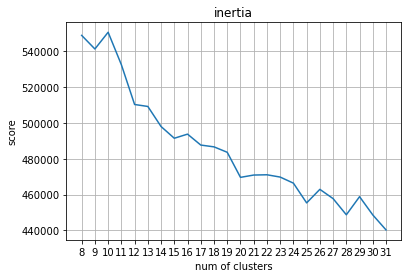

In [32]:
plt.figure()
plt.plot(k_values, inertia_scores)
plt.xlabel('num of clusters')
plt.ylabel('score')
plt.title('inertia')
plt.xticks(k_values)
plt.grid()
#plt.ylim(0,580000)
plt.show()

Based on the graph, there is a decrease in the slope at the following number of clusters: 20, 25, 27.

# View Cluster Features
For Kmeans, the optimal number of clusters are **15, 17, and 25.** As 25 has the lowest inertia, let's try using 25 clusters.

### 25 clusters

In [34]:
#instantiate KMeans with 25 clusters
kmeans_model25 = KMeans(n_clusters=27,init="k-means++",n_init=1, verbose=1)
#fitting KMeans on first 350 PCs
kmeans_model25.fit(PCA_components.iloc[:,0:230])

Initialization complete
Iteration 0, inertia 694455.4731142943
Iteration 1, inertia 481919.67981071305
Iteration 2, inertia 467815.1681664576
Iteration 3, inertia 459132.39873677515
Iteration 4, inertia 454437.7310648751
Iteration 5, inertia 453356.00587492145
Iteration 6, inertia 452965.5070717301
Iteration 7, inertia 452705.86066626234
Iteration 8, inertia 452626.73042858724
Iteration 9, inertia 452560.1318376898
Iteration 10, inertia 452510.58085393347
Iteration 11, inertia 452502.8932756247
Iteration 12, inertia 452497.339164819
Iteration 13, inertia 452483.3696786129
Iteration 14, inertia 452476.9594187161
Iteration 15, inertia 452471.6330209836
Iteration 16, inertia 452457.649434923
Iteration 17, inertia 452456.5505468683
Iteration 18, inertia 452456.5356721108
Converged at iteration 18: center shift 4.004814458260188e-07 within tolerance 9.931390534396236e-07.


KMeans(n_clusters=27, n_init=1, verbose=1)

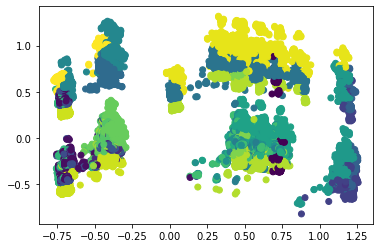

In [35]:
#let's take a look at the first 2 PCs with the labels generated from KMeans
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], c=kmeans_model25.labels_)
plt.show()

The are some vague clusters that can be seen from the first 2 PC but quite evidently they are not interpretable at this point.

Let's save the model in order to perform cluster analysis (in the next notebook). Note, I will also perform LDA topic modelling in parallel and compare the results of each model to try and find a cluster(s) of fake reviews.

In [36]:
import joblib

In [38]:
#saving model to computer to be used for later analysis
joblib.dump(kmeans_model25, 'kmeans_model25_Aumented_Df.pkl')

['kmeans_model25_Aumented_Df.pkl']

##### Saving data
We can also save the dataframe with the cluster labels. We will need to perform matrix multiplication to convert the reviews from principal components back to the original features.

In [39]:
#getting 2 matrices
# 1) data with principal components (PCs)
# 2) PCs and features
# only getting 350 PCs as those the model was fit only on those PCs
data_pc_matrix = PCA_components.iloc[:,0:230].to_numpy()
pc_feature_matrix = pca.components_[0:230,:]

In [40]:
#performing matrix multiplication to get the reviews back in terms of the original features; will then save this reconstructed data to a dataframe
df_recon = pd.DataFrame(np.matmul(data_pc_matrix,pc_feature_matrix), columns=df_final.columns)

In [41]:
#adding cluster labels to the reconstructed dataframe
df_recon['cluster'] = kmeans_model25.labels_

In [42]:
#saving the df to the computer in a compressed h5 format (saves faster than other compression techniques)
df_recon.to_hdf('df_recon_25_kmeans_Aumented_DF.h5', key='df', mode='w')